In [1]:
import pandas as pd
import importlib
import sys
from tqdm import tqdm
import time
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import contextily as cx
from datetime import datetime, timedelta
from scipy.signal import butter,filtfilt

In [2]:
from readers.InSAR import InSAR
from readers.GNSS import GNSS

In [3]:
insar = InSAR('data/time_series_Saarland_Orbit139_update.nc')
insar_df = insar.get_df()
master_day = insar.get_master_day() # I think that we should completely discard gnss stations that do not have the reference day
gnss = GNSS('data/selected_stations_dates.csv', )
master_day = insar.get_master_day() # I think that we should completely discard gnss stations that do not have the reference day
gnss.compute_standarized_dataset_up(master_day, unit="mm") #there is a misspelling in the function name but im too lazy to refactor all the changes xds
gnss.compute_and_remove_outliers()
gnss.compute_periodic_function(use_sigma=True)
gnss_df = gnss.get_df()

/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: BIWI does not have data for 6625. Using closest day 6624 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: D525 does not have data for 6625. Using closest day 5920 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: LUX1 does not have data for 6625. Using closest day 6820 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: MOLV does not have data for 6625. Using closest day 6624 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: MOUS does not have data for 6625. Using closest day 6624 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: OBER does not have data for 6625. Using closest day 6624 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: SIM1 does not have data for 6625. Usi

In [4]:
gnss_df

site  YYMMMDD  yyyy.yyyy  __MJD  week  d  reflon  _e0(m)  __east(m)  \
0      BAS4  15NOV27  2015.9042  57353  1872  5     5.9    2840   0.335746   
1      BAS4  15NOV28  2015.9069  57354  1872  6     5.9    2840   0.338036   
2      BAS4  15NOV29  2015.9097  57355  1873  0     5.9    2840   0.334461   
3      BAS4  15NOV30  2015.9124  57356  1873  1     5.9    2840   0.334722   
4      BAS4  15DEC01  2015.9151  57357  1873  2     5.9    2840   0.335756   
...     ...      ...        ...    ...   ... ..     ...     ...        ...   
49412  WALF  20FEB18  2020.1314  58897  2093  2     6.1    2280   0.337429   
49413  WALF  20FEB19  2020.1342  58898  2093  3     6.1    2280   0.337969   
49414  WALF  20FEB20  2020.1369  58899  2093  4     6.1    2280   0.338318   
49415  WALF  20FEB21  2020.1396  58900  2093  5     6.1    2280   0.338762   
49416  WALF  20FEB22  2020.1424  58901  2093  6     6.1    2280   0.338489   

       ____n0(m)  ...  __corr_eu  __corr_nu  _latitude(deg)  _longitude(deg)  \
0        5492790  ...  -0.051890  -0.051327       49.567937         5.939266   
1        5492790  ...  -0.067490  -0.044838       49.567937         5.939266   
2        5492790  ...  -0.038736  -0.063397       49.567937         5.939266   
3        5492790  ...  -0.037520  -0.062460       49.567937         5.939266   
4        5492790  ...  -0.063112  -0.056829       49.567937         5.939266   
...          ...  ...        ...        ...             ...              ...   
49412    5502823  ...   0.001673  -0.046057       49.658142         6.131582   
49413    5502823  ...   0.009617  -0.027913       49.658142         6.131582   
49414    5502823  ...   0.015142  -0.018189       49.658142         6.131582   
49415    5502823  ...   0.014884   0.000672       49.658142         6.131582   
49416    5502823  ...   0.018324  -0.045957       49.658142         6.131582   

       __height(m)   day  st_up(mm)    zscore  periodic_func(mm)  \
0        375.75093  5809     -3.546  0.070941          -2.313688   
1        375.74875  5810     -5.717 -0.015389          -2.338204   
2        375.74933  5811     -5.137  0.007675          -2.362599   
3        375.74901  5812     -5.463 -0.005288          -2.386865   
4        375.74651  5813     -7.958 -0.104503          -2.410996   
...            ...   ...        ...       ...                ...   
49412    292.40167  7353      6.138  0.453454          -0.812665   
49413    292.41336  7354     17.830  1.277938          -0.837607   
49414    292.41906  7355     23.531  1.679956          -0.862204   
49415    292.39791  7356      2.379  0.188381          -0.886449   
49416    292.38956  7357     -5.970 -0.400365          -0.910335   

       st_up_no_year(mm)  
0              -1.232312  
1              -3.378796  
2              -2.774401  
3              -3.076135  
4              -5.547004  
...                  ...  
49412           6.950665  
49413          18.667607  
49414          24.393204  
49415           3.265449  
49416          -5.059665  

[49169 rows x 28 columns]

In [59]:
# We will focus on a particular site
site_name = "DILL"
site_df = gnss_df[gnss_df["site"] == site_name]
site_gdf = gnss.get_sites_gdf().loc[site_name]
site_lat = site_gdf["_latitude(deg)"]
site_long = site_gdf["_longitude(deg)"]

In [60]:
# and a particular k
k = 5
selected_insar = insar.get_k_closest_points(site_long, site_lat, k = k) # takes ~30sec

### Plot vertical displacement and position on the map

In [62]:
# useful stuff for plotting
cols = selected_insar.iloc[:,2:-2]
days = [int(c[4:]) for c in cols.columns]
assert len(cols.columns) == 112
x = pd.to_datetime(days, origin='2000-01-01', unit='D')
gnss_selected_dates = site_df[site_df['day'].isin(days)]
gnss_days = gnss_selected_dates["day"].values

In [63]:
def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings
    
    https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

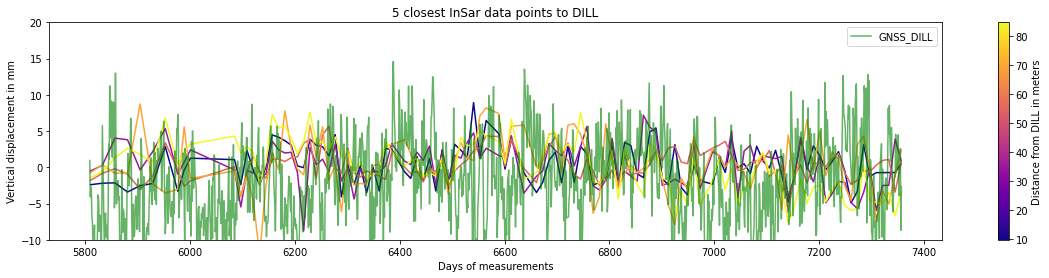

In [64]:
# plot using all gnss days, outliers removed, no year correction
fig, ax = plt.subplots()
fig.set_figwidth(20)
lc = multiline([days]*5, cols.values, selected_insar["distance(m)"], cmap='plasma', lw=1.5)
axcb = fig.colorbar(lc)
ax.plot(site_df["day"], site_df['st_up(mm)'], lw=1.5, c="green", alpha= 0.6,label = f"GNSS_{site_name}") # without limit gnss reaches 140 at some point
ax.set_ylim([-10,20])
axcb.set_label(f'Distance from {site_name} in meters')
ax.set_title(f'{k} closest InSar data points to {site_name}')
ax.set_ylabel("Vertical displacement in mm")
ax.set_xlabel("Days of measurements")
ax.legend()

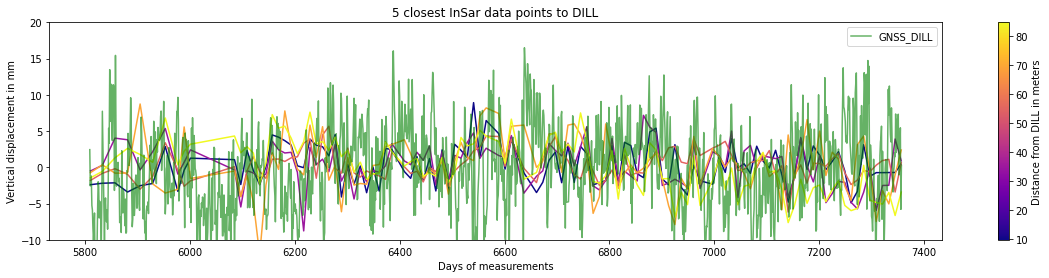

In [65]:
# plot using all gnss days, outliers removed, year correction
fig, ax = plt.subplots()
fig.set_figwidth(20)
lc = multiline([days]*5, cols.values, selected_insar["distance(m)"], cmap='plasma', lw=1.5)
axcb = fig.colorbar(lc)
ax.plot(site_df["day"], site_df['st_up_no_year(mm)'], lw=1.5, c="green", alpha= 0.6,label = f"GNSS_{site_name}") # without limit gnss reaches 140 at some point
ax.set_ylim([-10,20])
axcb.set_label(f'Distance from {site_name} in meters')
ax.set_title(f'{k} closest InSar data points to {site_name}')
ax.set_ylabel("Vertical displacement in mm")
ax.set_xlabel("Days of measurements")
ax.legend()

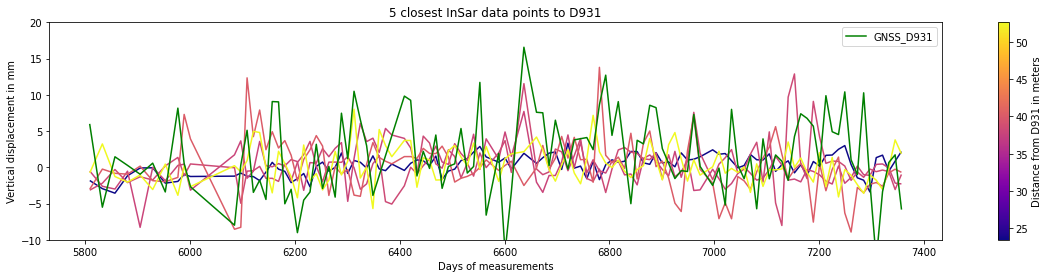

In [11]:
# plot using only days matching with insar, outliers removed, no year correction
fig, ax = plt.subplots()
fig.set_figwidth(20)
lc = multiline([days]*5, cols.values, selected_insar["distance(m)"], cmap='plasma', lw=1.5)
axcb = fig.colorbar(lc)
ax.plot(gnss_days, gnss_selected_dates['st_up(mm)'], lw=1.5, c="green", alpha= 1,label = f"GNSS_{site_name}") # without limit gnss reaches 140 at some point
ax.set_ylim([-10,20])
axcb.set_label(f'Distance from {site_name} in meters')
ax.set_title(f'{k} closest InSar data points to {site_name}')
ax.set_ylabel("Vertical displacement in mm")
ax.set_xlabel("Days of measurements")
ax.legend()

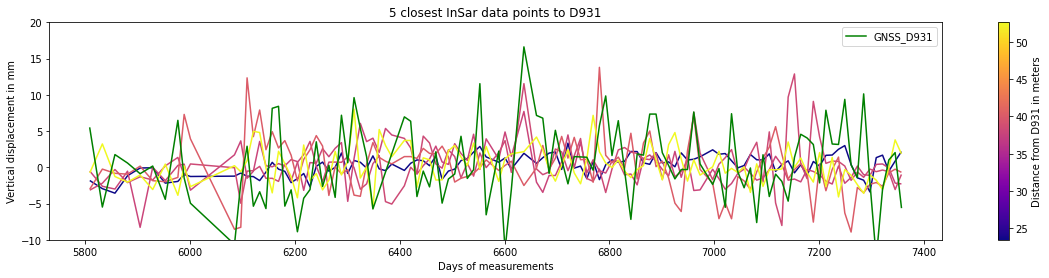

In [40]:
# plot using only days matching with insar, outliers removed, year_correction
fig, ax = plt.subplots()
fig.set_figwidth(20)
lc = multiline([days]*5, cols.values, selected_insar["distance(m)"], cmap='plasma', lw=1.5)
axcb = fig.colorbar(lc)
ax.plot(gnss_days, gnss_selected_dates['st_up_no_year(mm)'], lw=1.5, c="green", alpha= 1,label = f"GNSS_{site_name}") # without limit gnss reaches 140 at some point
ax.set_ylim([-10,20])
axcb.set_label(f'Distance from {site_name} in meters')
ax.set_title(f'{k} closest InSar data points to {site_name}')
ax.set_ylabel("Vertical displacement in mm")
ax.set_xlabel("Days of measurements")
ax.legend()

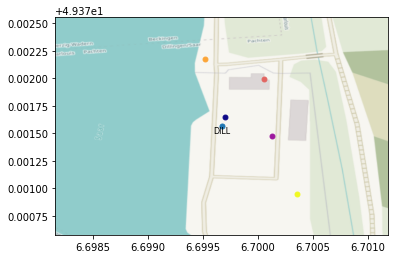

In [66]:
ax = plt.gca()
# plot gnss station
bbox = gnss.get_bbox_around_site(site_name)
gpd.GeoSeries(bbox).plot(ax=ax, color='green', alpha=0) #this is just to make image show everything within bounds
gpd.GeoSeries(site_gdf.geometry).plot(ax=ax, markersize=25)
ax.text(site_gdf.geometry.x,
        site_gdf.geometry.y,
        site_gdf.name,
        fontsize=8, ha='center', va='top')
# plot k nearest insar points
cmap = lc.get_cmap()
d = selected_insar["distance(m)"]
d = (d - d.min())/(d.max()-d.min())
for i in range(k):
    row = selected_insar.iloc[i,:]
    gpd.GeoSeries(Point(row["longitude"], row["latitude"])).plot(ax=ax, markersize=24, color=cmap(d.iloc[i]))
cx.add_basemap(ax=ax, crs = 'EPSG:4326', attribution='')

### Low pass filter

In [68]:
# Filter requirements.
fs_insar = 1/(2*7*24*60*60)                                              # sample rate, Hz (once every 2 weeks)
fs_gnss = 1/(24*60*60)                                                   # once every day
cutoffs_insar = [fs_insar/5, fs_insar/10, fs_insar/20, fs_insar/40]      # desired cutoff frequency of the filter, Hz
cutoffs_gnss = [fs_gnss/5, fs_gnss/25, fs_gnss/100, fs_gnss/500] 
nyq_insar = 0.5 * fs_insar                                               # Nyquist Frequency
nyq_gnss = 0.5 * fs_gnss
order = 5                                                                # sin wave can be approx represented as quadratic

In [69]:
def butter_lowpass_filter(data, cutoff, order, nyq):
    normal_cutoff = cutoff / nyq # normalize
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

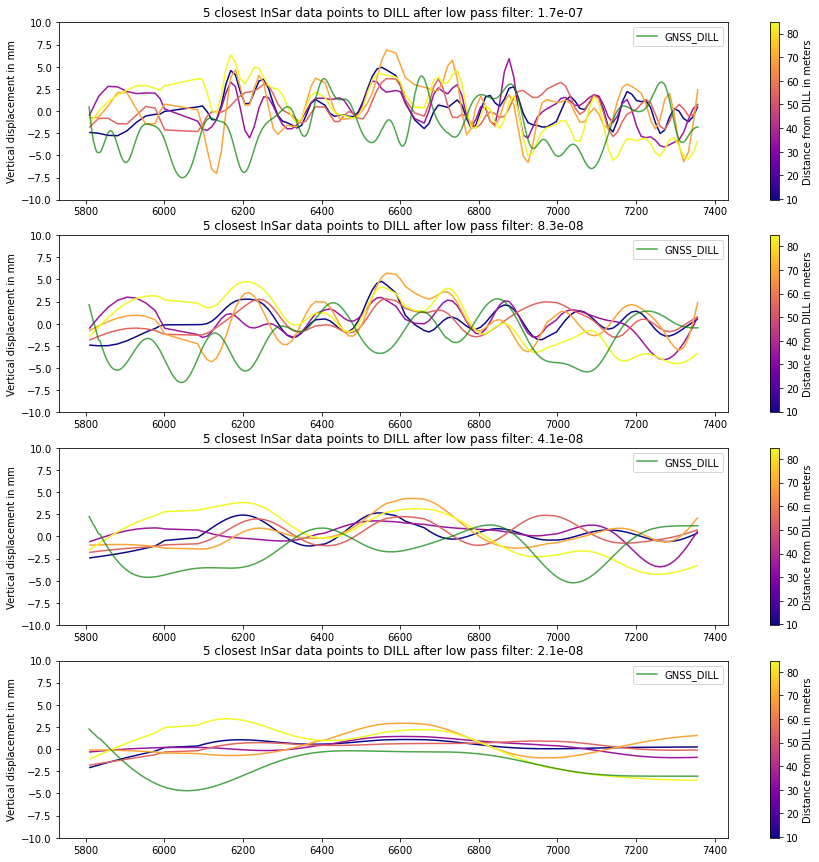

In [70]:
# we filter complete gnss signal not its downsampled version
plt.figure(figsize=(15, 15))

for i, cutoff in enumerate(cutoffs_insar):
    plt.subplot(len(cutoffs_insar), 1,i+1)
    filtered = [butter_lowpass_filter(row, cutoff, order, nyq_insar) for row in cols.values]    
    lc = multiline([days]*5, filtered, selected_insar["distance(m)"], cmap='plasma', lw=1.5)
    axcb = plt.colorbar(lc)
    plt.plot(site_df["day"], butter_lowpass_filter(site_df['st_up(mm)'], cutoff, order, nyq_gnss), lw=1.5, alpha=0.7, c="green", label = f"GNSS_{site_name}") # without limit gnss reaches 140 at some point
    plt.ylim([-10,10])
    axcb.set_label(f'Distance from {site_name} in meters')
    plt.title(f'{k} closest InSar data points to {site_name} after low pass filter: {cutoff :.1e}')
    plt.ylabel("Vertical displacement in mm")
    plt.legend()    

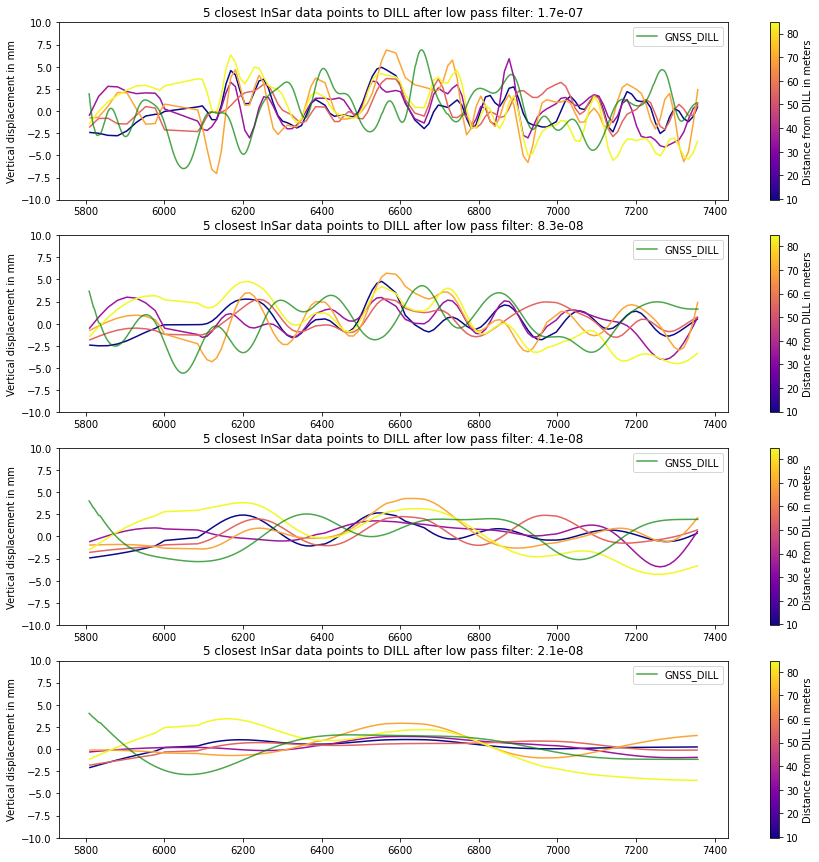

In [71]:
# we filter complete gnss signal not its downsampled version
plt.figure(figsize=(15, 15))

for i, cutoff in enumerate(cutoffs_insar):
    plt.subplot(len(cutoffs_insar), 1,i+1)
    filtered = [butter_lowpass_filter(row, cutoff, order, nyq_insar) for row in cols.values]    
    lc = multiline([days]*5, filtered, selected_insar["distance(m)"], cmap='plasma', lw=1.5)
    axcb = plt.colorbar(lc)
    plt.plot(site_df["day"], butter_lowpass_filter(site_df['st_up_no_year(mm)'], cutoff, order, nyq_gnss), lw=1.5, alpha=0.7, c="green", label = f"GNSS_{site_name}") # without limit gnss reaches 140 at some point
    plt.ylim([-10,10])
    axcb.set_label(f'Distance from {site_name} in meters')
    plt.title(f'{k} closest InSar data points to {site_name} after low pass filter: {cutoff :.1e}')
    plt.ylabel("Vertical displacement in mm")
    plt.legend()    

### Derivative kernel

In [27]:
def take_n_derivative(x:float, y:float, n:int = 1):
    """
    This is actually derivative approximation through finite difference.
    
    Returns array of length n where the first value is 0
    """
    dy = np.diff(y, n=n)
    dx = np.diff(x, n=n)
    return np.pad(dy/dx, (1,0))

In [56]:
# taking derivative after smoothing
der_days = days[1:]
_cols = cols.apply(lambda x: butter_lowpass_filter(x, cutoffs_insar[0], order, nyq_insar), raw=True, axis = 1)
der_cols = _cols.apply(lambda x: take_n_derivative(days, x), raw=True, axis = 1).iloc[:, 1:]
gnss_days = site_df["day"].values
der_gnss = take_n_derivative(gnss_days, butter_lowpass_filter(site_df["st_up_no_year(mm)"].values, cutoffs_insar[0], order, nyq_gnss))[1:]

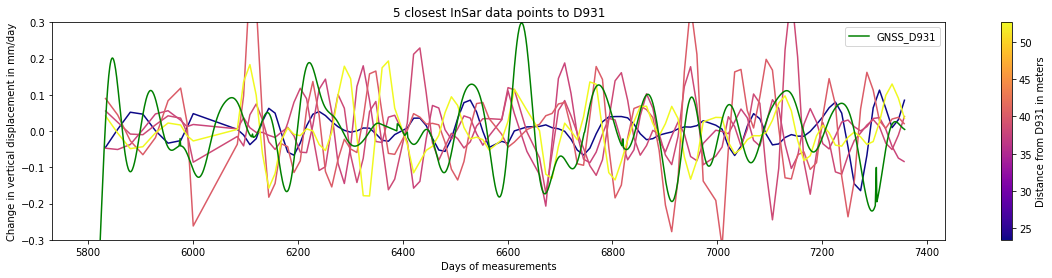

In [58]:
# plot derivative plots
fig, ax = plt.subplots()
fig.set_figwidth(20)
lc = multiline([der_days]*5, der_cols.values, selected_insar["distance(m)"], cmap='plasma', lw=1.5)
axcb = fig.colorbar(lc)
ax.plot(gnss_days[1:], der_gnss, lw=1.5, c="green", alpha= 1,label = f"GNSS_{site_name}") # without limit gnss reaches 140 at some point
axcb.set_label(f'Distance from {site_name} in meters')
ax.set_title(f'{k} closest InSar data points to {site_name}')
ax.set_ylim([-0.3, 0.3])
ax.set_ylabel("Change in vertical displacement in mm/day")
ax.set_xlabel("Days of measurements")
ax.legend()